In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
dataset = load_dataset(dataset_name)
dataset = dataset["train"]
dataset[0]

{'input_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080>,
 'edit_prompt': 'make nfs 2005 photorealistic',
 'edited_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080>}

In [2]:
from torchvision import transforms
import torchvision.transforms.functional as F
import torch

T = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(512, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(512),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
N = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

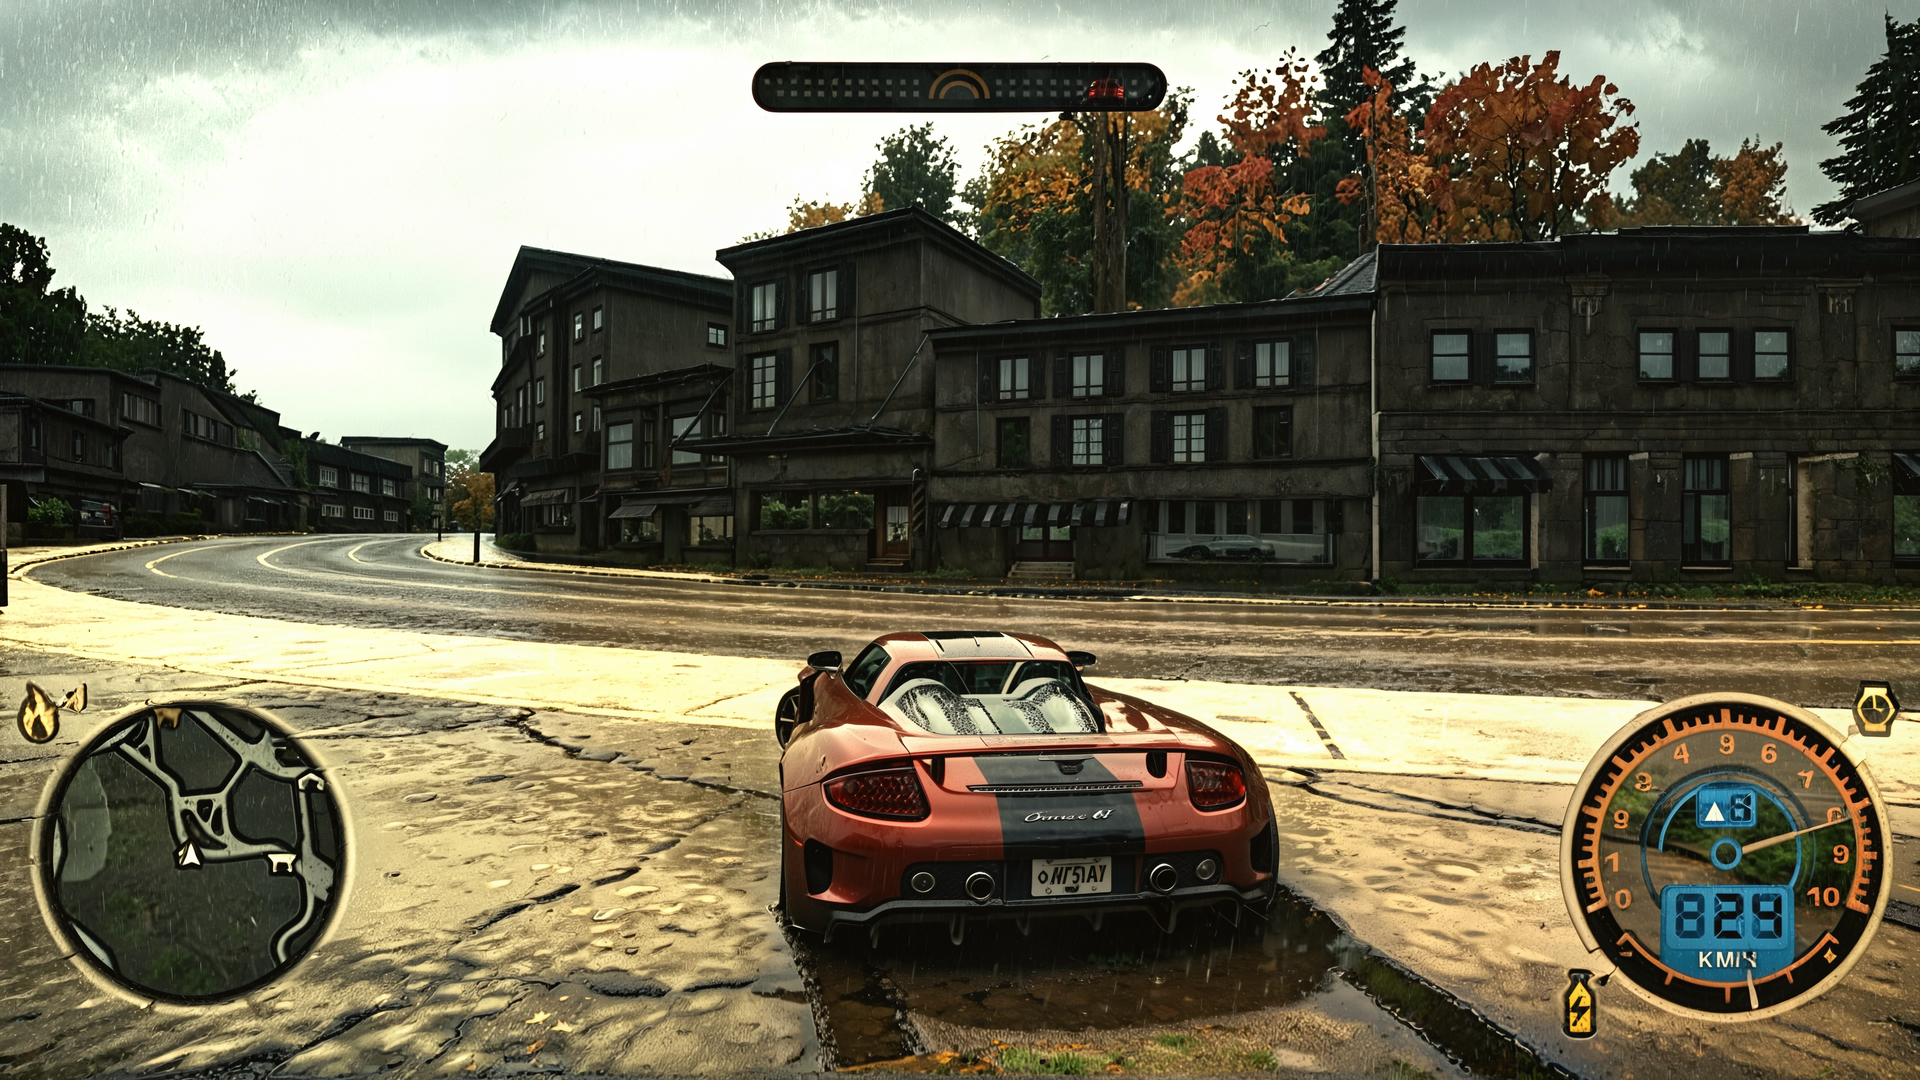

In [3]:
dataset[0]["edited_image"]

In [81]:
image[None].shape, image.shape

(torch.Size([1, 3, 512, 512]), torch.Size([3, 512, 512]))

In [84]:
image_tensor.shape

torch.Size([1, 3, 512, 512])

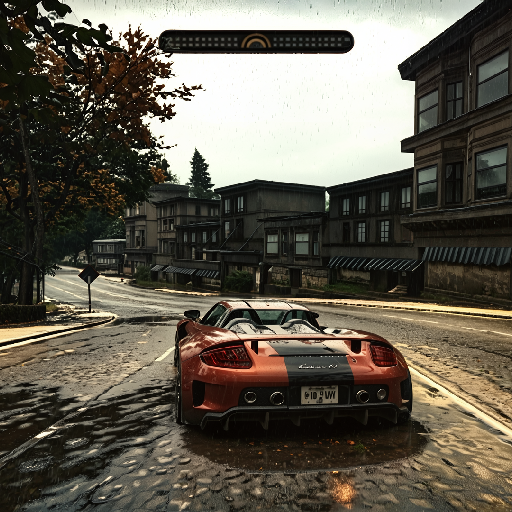

In [14]:
pos = 150
# image = T(dataset[pos]["input_image"].convert("RGB"))
# image = T(dataset[pos]["input_image"].convert("RGB"))
# image = T(dataset[pos]["input_image"])
image = T(dataset[pos]["edited_image"])
# image = T(dataset[pos]["input_image"])
# image_tensor = F.to_tensor(image).unsqueeze(0).cuda().to(torch.float16)
image_tensor = image.unsqueeze(0).cuda().to(torch.float16)
# image
transforms.ToPILImage()((image * 0.5 + 0.5).cpu())
# transforms.ToPILImage()(image)
# image

### taesd

In [12]:
from diffusers import AutoencoderTiny
import torch

vae = AutoencoderTiny.from_pretrained(
    "madebyollin/taesd",
    torch_device="cuda",
    torch_dtype=torch.float16,
).cuda()
vae = vae.to(torch.float16)
vae = vae.eval()

In [23]:
c_t = torch.randn(
    [1, 3, 512, 512],
    # [1, 3, 720, 1280],
    device="cuda",
    dtype=torch.float16,
)

In [97]:
vae.encode(c_t, False)[0].shape

torch.Size([1, 4, 64, 64])

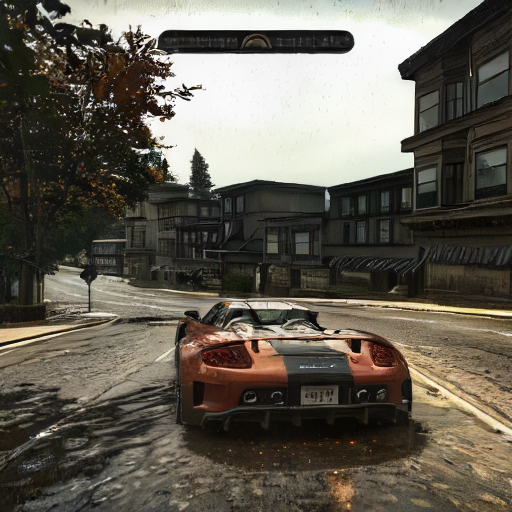

In [15]:
with torch.no_grad():
    output_image = vae.decode(
        vae.encode(
            image_tensor,
            False,
        )[0],
        False,
    )[
        0
    ].clamp(-1, 1)
output_pil = transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).cpu())
output_pil

### DC-AE

In [4]:
from diffusers import AutoencoderDC

ae = AutoencoderDC.from_pretrained(
    "mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers",
    torch_dtype=torch.float16,
).to("cuda")
ae = ae.to(torch.float16)
ae = ae.eval()

In [41]:
ae.encode(c_t, False)[0].shape

torch.Size([1, 32, 16, 16])

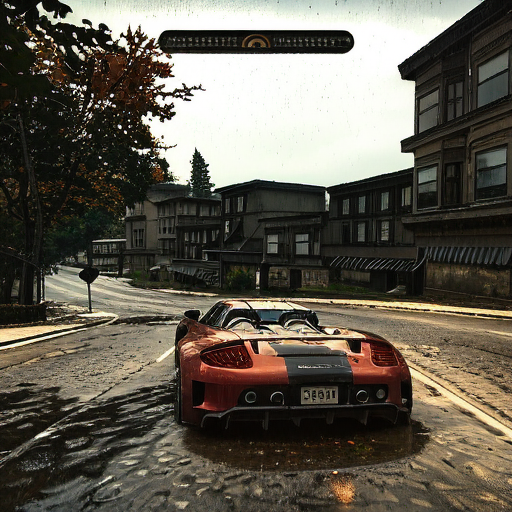

In [16]:
with torch.no_grad():
    output_image = ae.decode(
        ae.encode(
            image_tensor,
            False,
        )[0],
        False,
    )[
        0
    ].clamp(-1, 1)
output_pil = transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).cpu())
output_pil

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(ae), count_parameters(vae)

(312250275, 2445063)

In [ ]:
# https://huggingface.co/madebyollin/taesd/blob/main/config.json
AutoencoderTiny(
    in_channels=3,
    out_channels=3,
    encoder_block_out_channels=(64, 64, 64, 64),
    decoder_block_out_channels=(64, 64, 64, 64),
    act_fn="relu",
    upsample_fn="nearest",
    latent_channels=4,
    upsampling_scaling_factor=2,
    num_encoder_blocks=(1, 3, 3, 3),
    num_decoder_blocks=(3, 3, 3, 1),
    latent_magnitude=3,
    latent_shift=0.5,
    force_upcast=False,
    scaling_factor=1.0,
    shift_factor=0.0,
)

In [ ]:
# https://huggingface.co/mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers/blob/main/config.json
# Default Params
AutoencoderDC(
    in_channels=3,
    latent_channels=32,
    attention_head_dim=32,
    encoder_block_types=[
        "ResBlock",
        "ResBlock",
        "ResBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
    ],
    decoder_block_types=[
        "ResBlock",
        "ResBlock",
        "ResBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
    ],
    encoder_block_out_channels=[128, 256, 512, 512, 1024, 1024],
    decoder_block_out_channels=(128, 256, 512, 512, 1024, 1024),
    encoder_layers_per_block=(2, 2, 2, 3, 3, 3),
    decoder_layers_per_block=(3, 3, 3, 3, 3, 3),
    encoder_qkv_multiscales=((), (), (), (5,), (5,), (5,)),
    decoder_qkv_multiscales=((), (), (), (5,), (5,), (5,)),
    upsample_block_type="interpolate",
    downsample_block_type="Conv",
    decoder_norm_types="rms_norm",
    decoder_act_fns="silu",
    scaling_factor=0.41407,
)

In [20]:
ae.scaling_factor

/tmp/ipykernel_964783/2516981703.py:1: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderDC' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderDC's config object instead, e.g. 'unet.config.scaling_factor'.
  ae.scaling_factor


0.41407

In [63]:
# https://huggingface.co/mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers/blob/main/config.json
# Default Params
# tiny_ae = AutoencoderDC(
#     in_channels=3,
#     latent_channels=4,
#     attention_head_dim=32,
#     encoder_block_types=[
#         "ResBlock",
#         "ResBlock",
#         "ResBlock",
#         "EfficientViTBlock",
#         "EfficientViTBlock",
#         "EfficientViTBlock",
#     ],
#     decoder_block_types=[
#         "ResBlock",
#         "ResBlock",
#         "ResBlock",
#         "EfficientViTBlock",
#         "EfficientViTBlock",
#         "EfficientViTBlock",
#     ],
#     # encoder_block_out_channels=[64, 64, 64, 64],
#     encoder_block_out_channels=[64, 64, 64, 64, 64, 64],
#     decoder_block_out_channels=(64, 64, 64, 64, 64, 64),
#     # encoder_layers_per_block=(1, 2, 3, 3),
#     encoder_layers_per_block=(1, 2, 3, 3, 3, 3),
#     # decoder_layers_per_block=(3, 3, 3, 1),
#     decoder_layers_per_block=(3, 3, 3, 1, 3, 1),
#     # encoder_qkv_multiscales=((), (), (5,), (5,)),
#     encoder_qkv_multiscales=((), (), (), (5,), (5,), (5,)),
#     # decoder_qkv_multiscales=((), (), (5,), (5,)),
#     decoder_qkv_multiscales=((), (), (), (5,), (5,), (5,)),
#     upsample_block_type="interpolate",
#     downsample_block_type="Conv",
#     decoder_norm_types="rms_norm",
#     decoder_act_fns="silu",
#     scaling_factor=0.41407,
# )
tiny_ae = AutoencoderDC(
    in_channels=3,
    latent_channels=4,
    attention_head_dim=32,
    encoder_block_types=[
        "ResBlock",
        "ResBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
    ],
    decoder_block_types=[
        "ResBlock",
        "ResBlock",
        "EfficientViTBlock",
        "EfficientViTBlock",
    ],
    encoder_block_out_channels=[64, 64, 64, 64],
    decoder_block_out_channels=(64, 64, 64, 64),
    encoder_layers_per_block=(1, 2, 3, 3),
    decoder_layers_per_block=(3, 3, 3, 1),
    encoder_qkv_multiscales=((), (), (5,), (5,)),
    decoder_qkv_multiscales=((), (), (5,), (5,)),
    upsample_block_type="interpolate",
    downsample_block_type="Conv",
    decoder_norm_types="rms_norm",
    decoder_act_fns="silu",
    scaling_factor=0.41407,
)
tiny_ae = tiny_ae.eval().cuda()
tiny_ae = tiny_ae.to(torch.float16)

In [64]:
# vae.encode(c_t, False)[0].shape
tiny_ae.encode(c_t, False)[0].shape

torch.Size([1, 4, 64, 64])

In [65]:
count_parameters(tiny_ae), count_parameters(vae)

(1759815, 2445063)